In [2]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
os.chdir("OriginalFromAllenDB")

In [4]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
from modules import spike_train_generation

In [5]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()

1.0

In [6]:
h.nrn_load_dll("modfiles/x86_64/.libs/libnrnmech.so")

0.0

In [103]:

class AllenCell:
    def __init__(self, gid, soma_diam_multiplier=1.0):
        
        self._gid = gid
        self.synapses = []  # Keep track of all synapses
        self.netcons = []   # Keep track of NetCons
        self.stims = []     # Keep VecStims so they don't get garbage-collected
        self.vecs = []
        self.syn_locs = [] 
        
        description = Config().load('manifest.json')

        self.utils = Utils(description)
        self.h = self.utils.h
        self.Vinit = self.utils.description.data['conditions'][0]['v_init']
        # Cast all genome values to float
        for d in self.utils.description.data['genome']:
            if 'value' in d:
                d['value'] = float(d['value'])

        # Load morphology and parameters
        morphology_path = description.manifest.get_path('MORPHOLOGY')
        self.utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
        self.utils.load_cell_parameters()
        self.setup_morphology(soma_diam_multiplier)
        self._build_section_list()
    
    def setup_morphology(self,soma_diam_multiplier):

        self.soma = self.h.soma
        self.h.soma[0].diam *= soma_diam_multiplier
        self.dend = list(self.h.dend) if hasattr(self.h, 'dend') else []
        self.apic = list(self.h.apic) if hasattr(self.h, 'apic') else []
        self.axon = list(self.h.axon) if hasattr(self.h, 'axon') else []
        from neuron import h

        # Step 1: Set distance origin once (assuming soma(0.5) is your origin)
        h.distance(0, self.soma[0](0.5))

        # Step 2: Classify dendrites into proximal/distal
        self.proximal_dends = []
        self.distal_dends = []

        for sec in self.dend:  # assume this is your SectionList of dendrites
            # Use the midpoint of the section to define its distance
            dist = h.distance(sec(0.5))
            if dist >= 20:
                self.proximal_dends.append(sec)
            if dist >= 100:
                self.distal_dends.append(sec)
            # if dist >= 20 and dist <100:
            #     self.proximal_dends.append(sec)
            # elif dist >= 100:
            #     self.distal_dends.append(sec)


    def _build_section_list(self):
        self.all = h.SectionList()
        for sec in h.allsec():
            self.all.append(sec)
    ######### need proximal and distal list. or at least don't place any synapses close to the soma
    def add_random_synapses_from_df(self, df, syn_name, syn_params, section_pool=None):
        """
        Adds synapses at random locations with input times from a DataFrame.

        Parameters:
        - df: DataFrame with 'node' and 'timestamps' columns
        - syn_name: string name of NMODL synapse mechanism
        - syn_params: dictionary of synapse parameters (e.g. gmax, tau, e)
        - section_pool: list of sections to randomly choose from (default = self.dend)
        """
        if section_pool is None:
            section_pool = self.dend  # Default to dendrites
            
        self.full_list = []
        if type(section_pool) == list:
            for item in section_pool:
                self.full_list += item
            section_pool = self.full_list

        for _, row in df.iterrows():
            timestamps = row['timestamps']
            
            if not timestamps:
                continue

            sec = random.choice(section_pool)
            loc = random.uniform(0.1, 0.9)
            self.syn_locs.append((sec, loc))
            # Create synapse
            syn = getattr(h, syn_name)(sec(loc))
            for param, val in syn_params.items():
                if hasattr(syn, param):
                    setattr(syn, param, val)

            # Create VecStim with spike times
            vec = h.Vector(timestamps)
            self.vecs.append(vec)
            stim = h.VecStim()
            stim.play(vec)
            self.stims.append(stim)

            nc = h.NetCon(stim, syn)
            nc.weight[0] = syn_params.get('initW', 0.001)

            self.synapses.append(syn)
            self.netcons.append(nc)


            
    def __str__(self):
        return f"AllenCell(soma={self.soma}, dendrites={len(self.dend)})"

In [104]:
syn_params =  {
            'initW': 1.2,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.34,
            'Dep': 0.,
            'Fac': 80.,
            'NMDA_ratio': 1.5
        }

In [9]:
PFR = pd.read_csv(os.path.join("..","pyrFiringRateAvg.csv"),delimiter=",")
PFR_time_shortened = np.array(PFR['Time'][PFR['Time'] >0])
PFR_firing_rate_shortened = np.array(PFR['AvgFiringRate'][PFR['Time'] >0])

In [10]:
def get_num_spikes(freq,dur):
    return int(freq * (dur / 1000))

In [11]:
stim_start, stim_end = 100,1000
freqs = [5,20,50,100]
event_times = []
for freq in freqs:
    event_times.append(np.linspace(stim_start,stim_end, get_num_spikes(freq, stim_end-stim_start)))

In [17]:
cell = AllenCell(0,soma_diam_multiplier=6)
syn_params =  {
            'initW': 1.2,
            'tau_r_AMPA': 5,
            'tau_d_AMPA': 4,
            'Use': 0.34,
            'Dep': 0.,
            'Fac': 80.,
            'NMDA_ratio': 1.5
        }
        # 'spec_syn_param': {
        #     'initW': 1.2,
        #     'tau_r_AMPA': 5,
        #     'tau_d_AMPA': 4,
        #     'Use': 0.34,
        #     'Dep': 0.,
        #     'Fac': 80.,
        #     'NMDA_ratio': 1.5
        # }

ts, vs,ics = [],[],[]
for i, time in enumerate(event_times):
    
    syn = getattr(h, "AMPA_NMDA_STP")(cell.proximal_dends[0](0.5))
    for param, val in syn_params.items():
        if hasattr(syn, param):
            setattr(syn, param, val)
    vec = h.Vector(time)
    stim = h.VecStim()
    stim.play(vec)
    nc = h.NetCon(stim, syn)
    nc.weight[0] = syn_params.get('initW', 0.001)

    vc = h.VClamp(cell.soma[0](0.5))
    vc.dur[0] = 1000   # ms
    vc.amp[0] = -70   # mV
 
    
    ic = h.Vector().record(vc._ref_i)
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

    # Simulation control
    h.finitialize(cell.Vinit)
    h.tstop = 1000.0  # ms
    h.run()
    
    ts.append(np.array(tvec))
    vs.append(np.array(vvec))
    ics.append(np.array(ic))

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


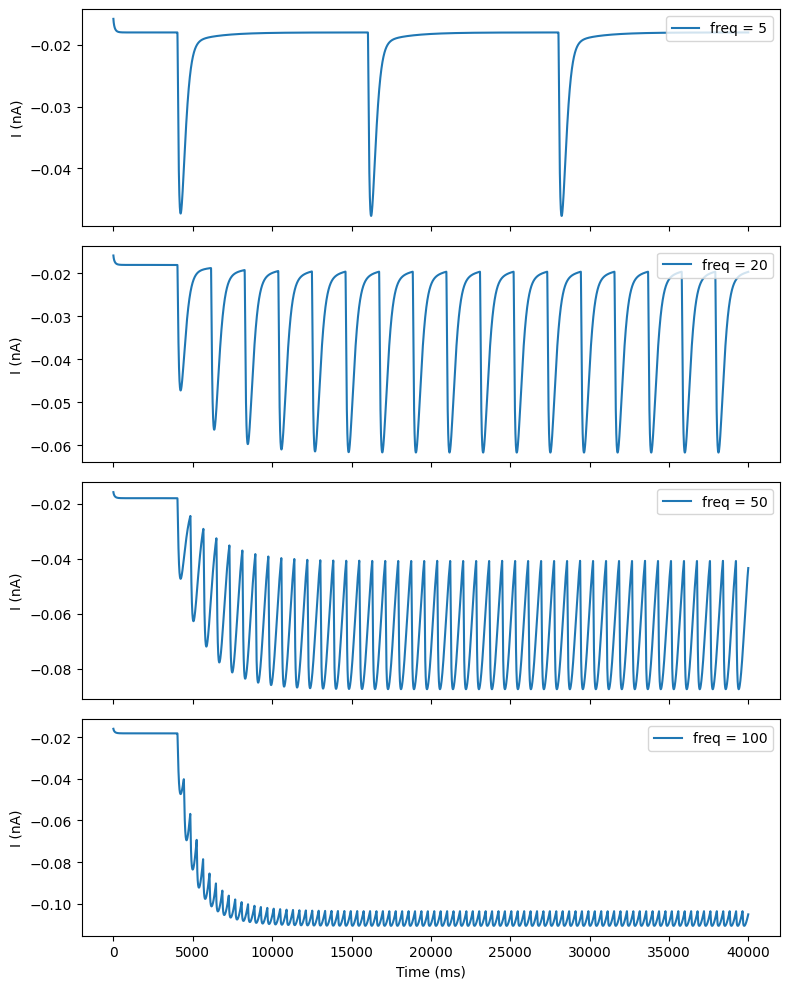

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

for i in range(4):
    T, V,Ics = np.array(ts[i]), np.array(vs[i]),np.array(ics[i])
    axes[i].plot(Ics[10:], label=f"freq = {freqs[i]}")
    axes[i].set_ylabel("I (nA)")
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


In [105]:
def inhomogeneous_poisson_through_num_points(lambdas, win_length):
    t = np.zeros(len(lambdas) * win_length)
    lambdas = np.divide(lambdas,1000/win_length)
    
    for i, lambd in enumerate(lambdas):

        num_points = np.random.poisson(lambd)

        if num_points >= win_length:
            t[i * win_length : (i + 1) * win_length] = 1
            continue

        random_inds = np.random.choice(a = np.arange(win_length), size = num_points, replace = False)
        spikes = np.zeros(win_length)
        spikes[random_inds] = 1
        t[i * win_length : (i + 1) * win_length] = spikes

    return t

In [113]:
N_stim = 20
all_spike_times = []
bin_size = 5


for i in range(N_stim):

    spikes=inhomogeneous_poisson_through_num_points(PFR_firing_rate_shortened,int(bin_size))
    time = np.arange(len(spikes))
    timestamps = time[spikes==1]
    all_spike_times.append(timestamps)


df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_spike_times) for t in times])
grouped_stim = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
len(grouped_stim["timestamps"][0])

5

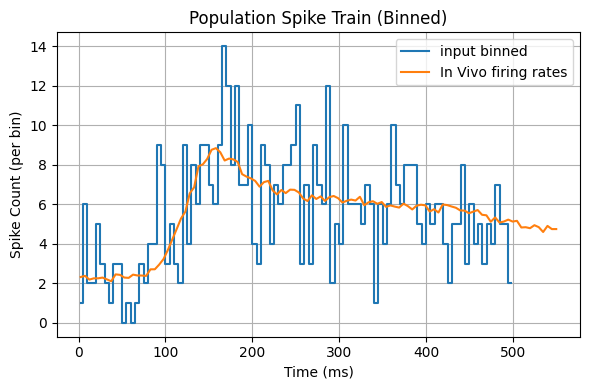

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Step 1: Combine all spike times into one flat array
all_spike_times = np.concatenate(grouped_stim['timestamps'].values)

# Step 2: Define bins
bin_width = 5  # ms
t_min = 0
t_max = 500
bins = np.arange(t_min, t_max + bin_width, bin_width)  # edges
counts, _ = np.histogram(all_spike_times, bins=bins)
counts = np.multiply(counts,200)
counts = np.divide(counts,N_stim)  
# Step 3: Plot as vertical lines or bar graph
bin_centers = bins[:-1] + bin_width / 2

plt.figure(figsize=(6, 4))

# Option 1: Line plot (PSTH style)
plt.plot(bin_centers, counts, drawstyle='steps-mid',label = "input binned")
plt.plot(PFR_time_shortened*1000,PFR_firing_rate_shortened,label = "In Vivo firing rates")
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count (per bin)')
plt.title('Population Spike Train (Binned)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [114]:

N_background = 10
all_bg_spikes = []
for i in range(N_background):
    background_spikes = spike_train_generation.homogeneous_poisson_timestamps(rate_hz=2, duration_ms=500)
    all_bg_spikes.append(background_spikes)

df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_bg_spikes) for t in times])
grouped = df.groupby('node_ids')['timestamps'].apply(list).reset_index()

print(grouped.shape)

(9, 2)


In [115]:
cell = AllenCell(0,soma_diam_multiplier=6)
cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends,cell.distal_dends])

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [116]:
cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends])

In [48]:

# print(f"Added {len(cell.synapses)} synapses")
# for i, syn in enumerate(cell.synapses):
#     print(f"Synapse {i}: {syn.get_segment().sec.name()} @ {syn.get_segment().x}")




In [117]:

from neuron import h, gui  # gui not needed in headless scripts

# Set recording vectors
tvec = h.Vector().record(h._ref_t)
vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

# Simulation control
h.finitialize(cell.Vinit)
h.dt = 0.025
h.tstop = 500.0  # ms
h.run()


0.0

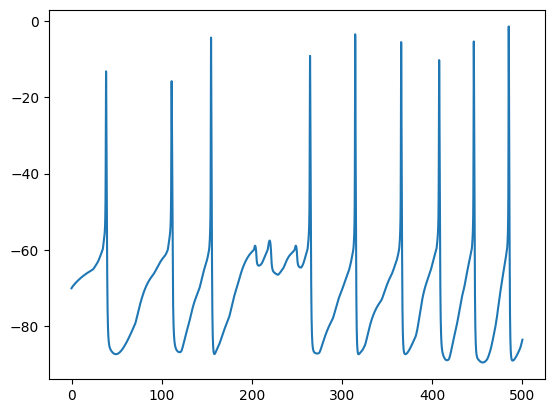

In [118]:
T,V = np.array(tvec),np.array(vvec)
plt.plot(T,V)
# plt.vlines(100,ymin=min(V),ymax=max(V),color = 'r')

Detected spikes at: [167.625 209.875 253.275 297.7   342.575 388.225 434.35  480.8  ]


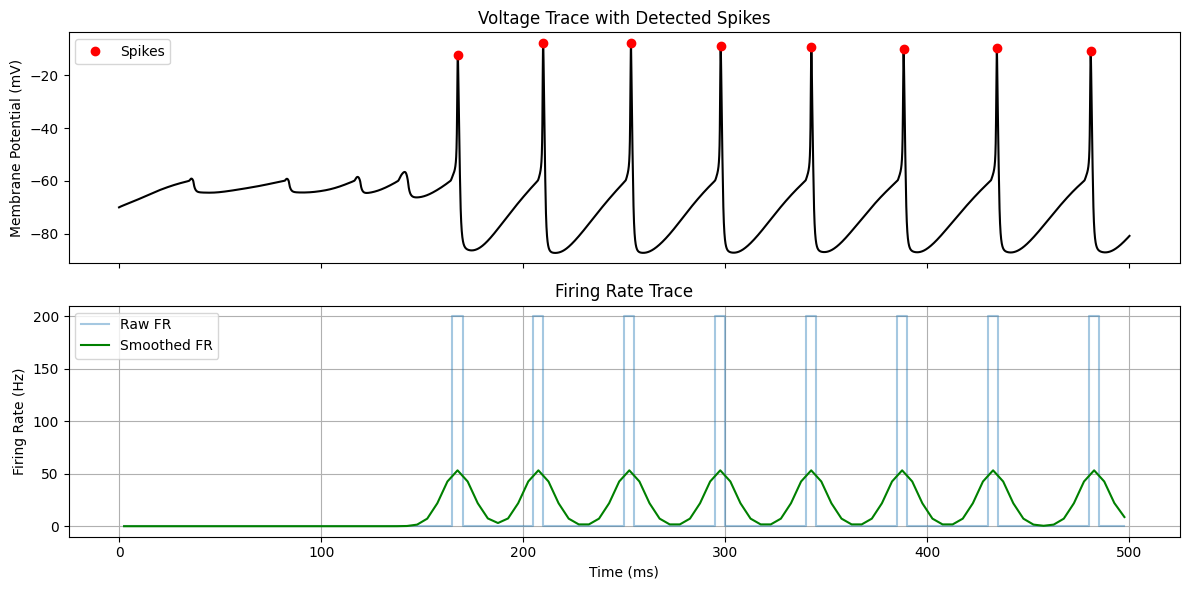

In [698]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d



# --- Step 1: Find spikes using find_peaks ---
# You can adjust height and distance to suit your actual trace
peaks, _ = find_peaks(V, height=-20, distance=2)  # height > 0 mV as a basic threshold
spike_times = T[peaks]

print("Detected spikes at:", spike_times)

# --- Step 2: Bin spike times to get firing rate ---
bin_width = 5  # ms
t_min = T[0]
t_max = T[-1]
bins = np.arange(t_min, t_max + bin_width, bin_width)
bin_centers = bins[:-1] + bin_width / 2

# Histogram: spike counts per bin
counts, _ = np.histogram(spike_times, bins=bins)

# Convert to Hz (spikes/sec in each bin)
firing_rate = counts / (bin_width / 1000)  # Hz

# Optional: Smooth with Gaussian filter
smoothed_fr = gaussian_filter1d(firing_rate, sigma=1.5)

# --- Step 3: Plot voltage and firing rate ---
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Voltage trace
axs[0].plot(T, V, color='black')
axs[0].plot(spike_times, V[peaks], 'ro', label='Spikes')
axs[0].set_ylabel('Membrane Potential (mV)')
axs[0].set_title('Voltage Trace with Detected Spikes')
axs[0].legend()

# Firing rate trace
axs[1].plot(bin_centers, firing_rate, drawstyle='steps-mid', alpha=0.4, label='Raw FR')
axs[1].plot(bin_centers, smoothed_fr, color='green', label='Smoothed FR')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Firing Rate (Hz)')
axs[1].set_title('Firing Rate Trace')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [17]:
import random

In [119]:
def run_cell(cell):
            # Set recording vectors
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(cell.soma[0](0.5)._ref_v)  # somatic Vm

    # Simulation control
    h.finitialize(cell.Vinit)
    h.dt = 0.025
    h.tstop = 500.0  # ms
    h.run()
    return tvec,vvec

In [120]:
No_Cells = 10
ts,vs = [],[]
cell = AllenCell(0,soma_diam_multiplier=6)

for i in range(No_Cells):
    
    cell.syn_locs = []
    cell.vecs = []
    cell.stims = []
    cell.synapses = []
    cell.netcons = []
    
    N_stim = 10
    all_spike_times = []
    bin_size = 5


    for i in range(N_stim):

        spikes=inhomogeneous_poisson_through_num_points(PFR_firing_rate_shortened,int(bin_size))
        time = np.arange(len(spikes))
        timestamps = time[spikes==1]
        all_spike_times.append(timestamps)


    df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_spike_times) for t in times])
    grouped_stim = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
    
    N_background = 20
    all_bg_spikes = []
    for i in range(N_background):
        background_spikes = spike_train_generation.homogeneous_poisson_timestamps(rate_hz=2, duration_ms=500)
        all_bg_spikes.append(background_spikes)

    df = pd.DataFrame([{'node_ids': node_id, 'timestamps': t} for node_id, times in enumerate(all_bg_spikes) for t in times])
    grouped = df.groupby('node_ids')['timestamps'].apply(list).reset_index()
    
    
    cell.add_random_synapses_from_df(grouped, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends,cell.distal_dends])
    cell.add_random_synapses_from_df(grouped_stim, "AMPA_NMDA_STP", syn_params, section_pool=[cell.proximal_dends])
    t,v = run_cell(cell)
    ts.append(t)
    vs.append(v)





warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [121]:
T = np.concatenate(np.array(ts),axis=0)
V = np.concatenate(np.array(vs),axis=0)

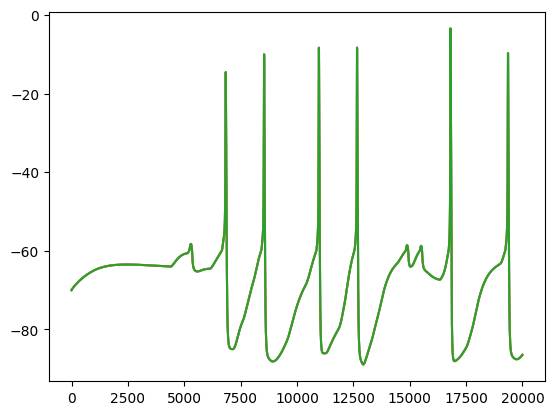

In [126]:
plt.plot(vs[0])
plt.plot(vs[1])
plt.plot(vs[2])
plt.show()

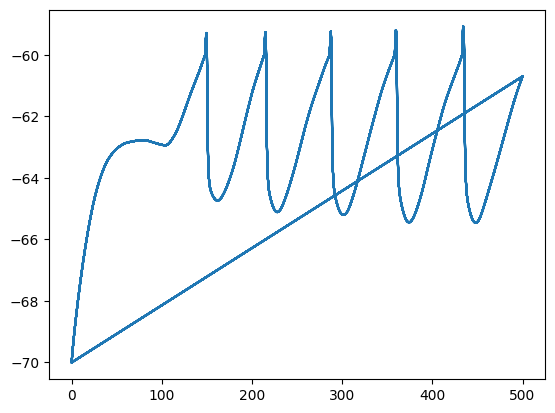

In [29]:
plt.plot(T,V)
plt.show()